In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import seaborn as sns


In [88]:
#loading raw data
#C:\Users\ANSD\OneDrive - Azubi Africa\master\versioning\Mlpipeline\data\raw\university_enrollment_2306.csv

enrollement = pd.read_csv("../data/raw/university_enrollment_2306.csv", index_col=0)
enrollement.head()

,course_type,year,enrollment_count,pre_score,post_score,pre_requirement,department
course_id,,,,,,,
1,classroom,2018,165,28.14,73.0,Beginner,Science
2,classroom,2020,175,79.68,86.0,None,Science
3,online,2016,257,57.24,80.0,NaN,Mathematics
4,online,2013,251,97.67,75.0,Beginner,Technology
5,classroom,2019,165,39.75,76.0,Beginner,Science


In [34]:
# checking features dtype
enrollement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850 entries, 1 to 1850
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   course_type       1850 non-null   object 
 1   year              1850 non-null   int64  
 2   enrollment_count  1850 non-null   int64  
 3   pre_score         1850 non-null   object 
 4   post_score        1665 non-null   float64
 5   pre_requirement   1761 non-null   object 
 6   department        1850 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 115.6+ KB


In [35]:
# making pre_score on the right dtype,
enrollement["pre_score"] = pd.to_numeric(enrollement["pre_score"], errors='coerce')

In [36]:
# check for missing values
enrollement.isna().sum()

course_type           0
year                  0
enrollment_count      0
pre_score           130
post_score          185
pre_requirement      89
department            0
dtype: int64

In [37]:
# for each column replace the missing values by the given value
## pre_score --> 0
## post_scoe --> 0
## pre_requirement --> None
## departement --> None
imp_dict ={"pre_score" : 0,
           "post_score" : 0,
           "pre_requirement": "None",
           "departement" : "unknown",
           "course_type" : "classroom",
           "year" : 2011}

In [38]:
#imputation
#for var, value in imp_dict.items():
enrollement.fillna(value = imp_dict, inplace = True)

In [41]:
cat_col = enrollement.select_dtypes("O").columns
cat_col

Index(['course_type', 'pre_requirement', 'department'], dtype='object')

In [43]:
num_col = enrollement.drop(columns="enrollment_count").select_dtypes(exclude = "O").columns
num_col

Index(['year', 'pre_score', 'post_score'], dtype='object')

In [48]:
num_col,cat_col

(Index(['year', 'pre_score', 'post_score'], dtype='object'),
 Index(['course_type', 'pre_requirement', 'department'], dtype='object'))

In [50]:
X = enrollement.drop(columns="enrollment_count")
X

,course_type,year,pre_score,post_score,pre_requirement,department
course_id,,,,,,
1,classroom,2018,28.14,73.0,Beginner,Science
2,classroom,2020,79.68,86.0,None,Science
3,online,2016,57.24,80.0,None,Mathematics
4,online,2013,97.67,75.0,Beginner,Technology
5,classroom,2019,39.75,76.0,Beginner,Science
...,...,...,...,...,...,...
1846,classroom,2018,60.01,81.0,Intermediate,Science
1847,online,2016,94.27,85.0,None,Technology
1848,online,2011,76.00,81.0,None,Mathematics


In [51]:
y = enrollement.enrollment_count
y

course_id
1       165
2       175
3       257
4       251
5       165
       ... 
1846    155
1847    261
1848    257
1849    256
1850    256
Name: enrollment_count, Length: 1850, dtype: int64

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [54]:
# Replace 'strategy' with your desired imputation strategy for missing values
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [56]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_col),
    ('cat', categorical_transformer, cat_col)
])


In [57]:
# If you have a classifier/regressor as the final step, add it to the pipeline
# For example, using a classifier:
from sklearn.ensemble import RandomForestClassifier
lin_regressor = LinearRegression()

# Combine the preprocessor and classifier (if applicable) into a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lin_regressor)  # Optional, only if you have a classifier/regressor as the final step
])


In [58]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=24)

In [59]:
# Example usage for training
pipeline.fit(X_train, y_train)

# Example usage for prediction
predictions = pipeline.predict(X_test)


In [60]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, predictions)

0.14328415651835852

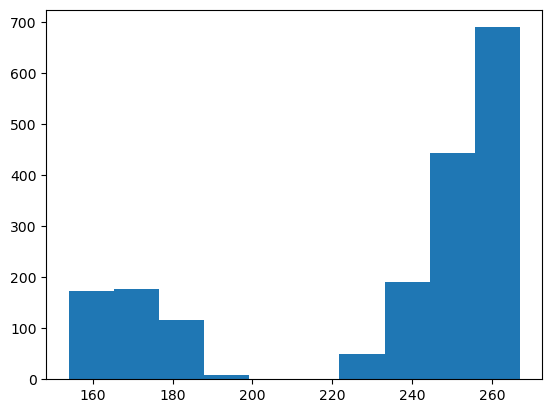

In [40]:
# visualisation
# Distribution on the target variable
plt.hist(data = enrollement, x = "enrollment_count");


In [99]:
# values account
for col in cat_col :
    print(enrollement[col].value_counts())

online       1375
classroom     475
Name: course_type, dtype: int64
None            802
Beginner        654
Intermediate    305
Name: pre_requirement, dtype: int64
Technology     719
Science        472
Mathematics    220
Math           220
Engineering    219
Name: department, dtype: int64


In [106]:
## lets clean the variable departemnt
enrollement["department"] = enrollement["department"].str.replace("Mathematics", "Math")

In [62]:
from sklearn.feature_selection import SequentialFeatureSelector

In [75]:
Mode_seq = SequentialFeatureSelector(LinearRegression(), n_features_to_select = "auto", scoring='neg_mean_absolute_error')

In [76]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocessor, Mode_seq,LinearRegression())

In [77]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['year', 'pre_score', 'post_score'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['course_type', 'pre_requirement', 'department'], dtype='object'))])),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select='auto',
                                           scoring='neg_mean_absolute_error')),
                ('linearregression', LinearRegression())])

In [87]:
pipeline[:-1].get_feature_names_out()

array(['num__year', 'num__pre_score', 'num__post_score',
       'cat__course_type_classroom', 'cat__course_type_online',
       'cat__pre_requirement_Beginner',
       'cat__pre_requirement_Intermediate', 'cat__pre_requirement_None',
       'cat__department_Engineering', 'cat__department_Math',
       'cat__department_Mathematics', 'cat__department_Science',
       'cat__department_Technology'], dtype=object)

In [69]:
Mode_seq.fit(X_train, y_train)

ValueError: could not convert string to float: 'online'

In [ ]:
Mode_seq.get_feature_names_out()

In [ ]:
Mode_seq.transform(X_train).shape

In [91]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(enrollement[cat_col])

OneHotEncoder()

In [95]:
one_hot_encoded = pd.get_dummies(enrollement, columns=cat_col)

In [96]:
one_hot_encoded

,year,enrollment_count,pre_score,post_score,course_type_classroom,course_type_online,pre_requirement_Beginner,pre_requirement_Intermediate,pre_requirement_None,department_Engineering,department_Math,department_Mathematics,department_Science,department_Technology
course_id,,,,,,,,,,,,,,
1,2018,165,28.14,73.0,1,0,1,0,0,0,0,0,1,0
2,2020,175,79.68,86.0,1,0,0,0,1,0,0,0,1,0
3,2016,257,57.24,80.0,0,1,0,0,0,0,0,1,0,0
4,2013,251,97.67,75.0,0,1,1,0,0,0,0,0,0,1
5,2019,165,39.75,76.0,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,2018,155,60.01,81.0,1,0,0,1,0,0,0,0,1,0
1847,2016,261,94.27,85.0,0,1,0,0,1,0,0,0,0,1
1848,2011,257,76,81.0,0,1,0,0,1,0,0,1,0,0
